In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple


Writing to /root/.config/pip/pip.conf
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install d2l pandas==1.5.3

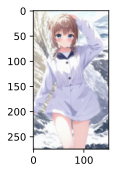

In [31]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l




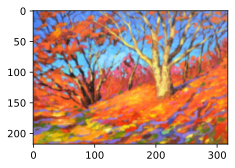

In [50]:
from PIL import Image
content_img = Image.open('/kaggle/input/style-transfer-image2/2.png').convert('RGB')
style_img=Image.open('/kaggle/input/style-transfer-image2/1.png').convert('RGB')
d2l.plt.imshow(style_img);
d2l.set_figsize()
d2l.plt.imshow(content_img);

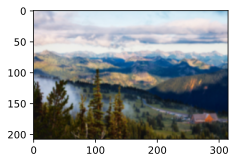

In [67]:
d2l.plt.imshow(style_img);

In [51]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])
#预处理
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)
#预处理的你操作
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [52]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [53]:
#抽取风格特征和内容特征的层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [54]:
#只保留前28层
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [55]:
#抽取特征
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [56]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [57]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

In [58]:
#得到每个通道的平均值
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [59]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [60]:
#尽可能使邻近的像素值相似，去除其中噪点
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [61]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [62]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [63]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [64]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

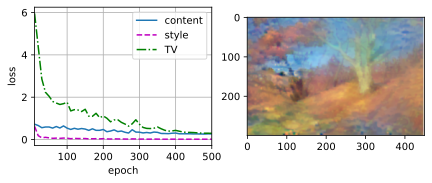

In [65]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)

content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [24]:
import matplotlib.pyplot as plt

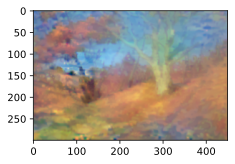

In [66]:
plt.imshow(postprocess(output))

In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from copy import deepcopy
import matplotlib.pyplot as plt

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G

class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = torch.sum((input-self.target) ** 2) / 2.0
        return input


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        a, b, c, d = input.size()
        G = gram_matrix(input)
        self.loss = torch.sum((G-self.target) ** 2) / (4.0 * b * b * c * d)
        return input


class ImageCoder:

    def __init__(self, image_size, device):

        self.device = device

        self.preproc = transforms.Compose([
            transforms.Resize(image_size),  # 改变图像大小
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 标准化
                                 std=[1, 1, 1]),
            transforms.Lambda(lambda x: x.mul_(255))
        ])

        self.postproc = transforms.Compose([
            transforms.Lambda(lambda x: x.mul_(1./255)),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1,1,1])
        ])

        self.to_image = transforms.ToPILImage()

    def encode(self, image_path):
        #image = Image.open(image_path)
        image = Image.open(image_path).convert('RGB')

        image = self.preproc(image)
        image = image.unsqueeze(0)
        return image.to(self.device, torch.float)

    def decode(self, image):
        image = image.cpu().clone()
        image = image.squeeze()
        image = self.postproc(image)
        image = image.clamp(0, 1)
        return self.to_image(image)

content_layers = ['conv_4_2'] # 内容损失函数使用的卷积层
style_layers = ['conv_1_1', 'conv2_1', 'conv_3_1', 'conv_4_1', 'conv5_1'] # 风格损失函数使用的卷积层
content_weights = [1] # 内容损失函数的权重
style_weights = [1e3, 1e3, 1e3, 1e3, 1e3] # 风格损失函数的权重
num_steps=200 # 最优化的步数


class Model:

    def __init__(self, device, image_size):

        cnn = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
        self.cnn = deepcopy(cnn) # 获取预训练的VGG19卷积神经网络
        self.device = device

        self.content_losses = []
        self.style_losses = []

        self.image_proc = ImageCoder(image_size, device)

    def run(self, content_image_path, style_image_path):

        content_image = self.image_proc.encode(content_image_path)
        style_image = self.image_proc.encode(style_image_path)

        self._build(content_image, style_image) # 建立损失函数
        output_image = self._transfer(content_image) # 进行最优化

        return self.image_proc.decode(output_image)

    def _build(self, content_image, style_image):

        self.model = nn.Sequential()

        block_idx = 1
        conv_idx = 1

        # 逐层遍历VGG19，取用需要的卷积层
        for layer in self.cnn.children():

            # 识别该层类型并进行编号命名
            if isinstance(layer, nn.Conv2d):
                name = 'conv_{}_{}'.format(block_idx, conv_idx)
                conv_idx += 1
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}_{}'.format(block_idx, conv_idx)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(block_idx)
                block_idx += 1
                conv_idx = 1
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(block_idx)
            else:
                raise Exception("invalid layer")

            self.model.add_module(name, layer)

            # 添加内容损失函数
            if name in content_layers:
                target = self.model(content_image).detach()
                content_loss = ContentLoss(target)
                self.model.add_module("content_loss_{}_{}".format(block_idx, conv_idx), content_loss)
                self.content_losses.append(content_loss)

            # 添加风格损失函数
            if name in style_layers:
                target_feature = self.model(style_image).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module("style_loss_{}_{}".format(block_idx, conv_idx), style_loss)
                self.style_losses.append(style_loss)

        # 留下有用的部分
        i = 0
        for i in range(len(self.model) - 1, -1, -1):
            if isinstance(self.model[i], ContentLoss) or isinstance(self.model[i], StyleLoss):
                break
        self.model = self.model[:(i + 1)]


    def _transfer(self, content_image):

        output_image = content_image.clone()
        random_image = torch.randn(content_image.data.size(), device=self.device)
        output_image = 0.4 * output_image + 0.6 * random_image

        optimizer = torch.optim.LBFGS([output_image.requires_grad_()])

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():

                optimizer.zero_grad()
                self.model(output_image)
                style_score = 0
                content_score = 0

                for sl, sw in zip(self.style_losses, style_weights):
                    style_score += sl.loss * sw
                for cl, cw in zip(self.content_losses, content_weights):
                    content_score += cl.loss * cw

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("iteration {}: Loss: {:4f} Style Loss: {:4f} Content Loss: {:4f}"
                          .format(run, loss.item(), style_score.item(), content_score.item()))
                return loss

            optimizer.step(closure)

        return output_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 256
model = Model(device, image_size)







In [21]:
style_image_path = '/kaggle/input/style-transfer-image2/2.png'
content_image_path = '/kaggle/input/style-transfer-image2/1.png'
#style_image_path = '/kaggle/input/test-image1/5.png'
#content_image_path = '/kaggle/input/test-image1/3.png'
out_image = model.run(content_image_path, style_image_path)
plt.imshow(out_image)
plt.show()

Optimizing..
iteration [50]: Loss:  nan Style Loss:  nan Content Loss:  nan


KeyboardInterrupt: 

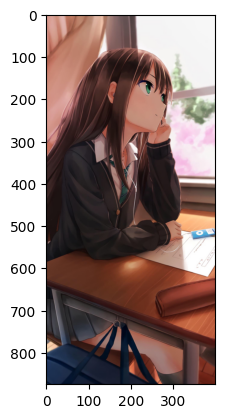

In [3]:
img=plt.imread('/kaggle/input/test-image1/5.png')
plt.imshow(img)